# Change Point Detection

## Problem statement

In [ ]:
# install packages, donwload data

# !pip install ruptures
# !git clone https://github.com/stalex2902/cpd-seminar.git

In [1]:
# all necessary imports 
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall, hausdorff, randindex

import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Part 1: simple data and 'ruptures' package

'Ruptures' is a useful python package for CPD with the implementation of basic untrainable CPD algorithms, e.g. binary segmentation, bottom-up segmentation, PELT, kernel CPD, etc. 

In this seminar, we'll consider several illustrative cases of its usage. See the [manual](https://centre-borelli.github.io/ruptures-docs/) for the documentation and the gallery of examples.

### Synthetic data

Ruptures allow to generate simple multivariate synthetic data: piesewise-constant and piecewise-linear signals with noise, piecewise normal and piecewise sinusoidal. Let's have generate simple 1D piecewise-constant time series with 5 CPs.

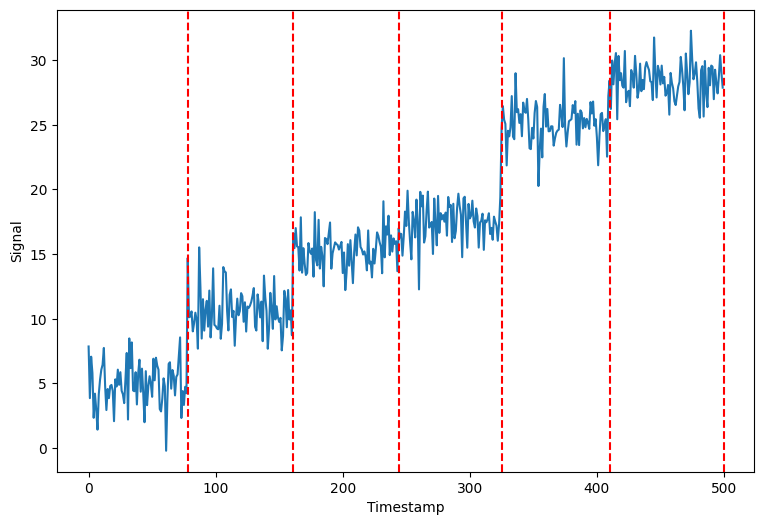

In [2]:
n_samples, n_dims, sigma = 500, 1, 1.5
n_cps = 5  # number of change points
signal, cps = rpt.pw_constant(n_samples, n_dims, n_cps, noise_std=sigma)

plt.figure(figsize=(9, 6))
plt.plot(signal)
for cp in cps:
    plt.axvline(cp, c="red", linestyle="--")
plt.xlabel("Timestamp")
plt.ylabel("Signal")
plt.show()

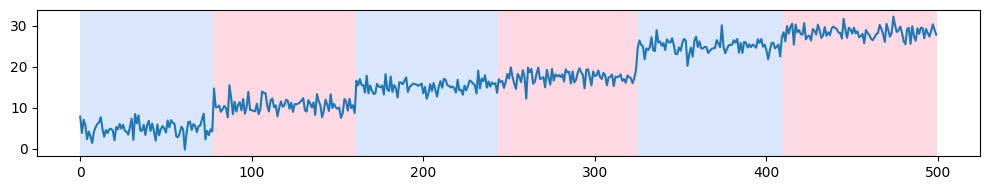

In [3]:
# built-in ruptures function for visualization
fig, ax_array = rpt.display(signal, cps)

### Simple models from ruptures

* Dynp: segmentation-based approach, uses dynamic programming for optimization
* PELT: uses cost function with penalty (see [paper](https://www.researchgate.net/publication/48180788_Optimal_Detection_of_Changepoints_With_a_Linear_Computational_Cost))
* KernelCPD: maps signal into RKHS and performs CPD there (e.g. [paper 1](https://arxiv.org/abs/1710.04556) and [paper 2](https://arxiv.org/abs/1202.3878))

See more basic methods and their details in the [manual](https://centre-borelli.github.io/ruptures-docs/user-guide/).


CPs predicted by Binseg: [80, 160, 245, 325, 410, 500]


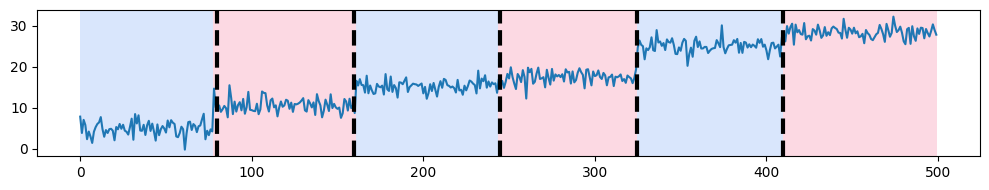

CPs predicted by Dynp: [80, 160, 245, 325, 410, 500]


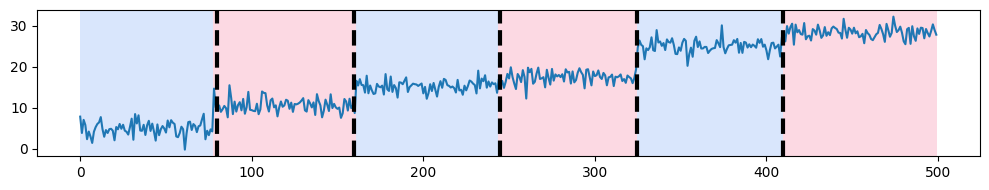

CPs predicted by PELT: [80, 160, 245, 325, 410, 500]


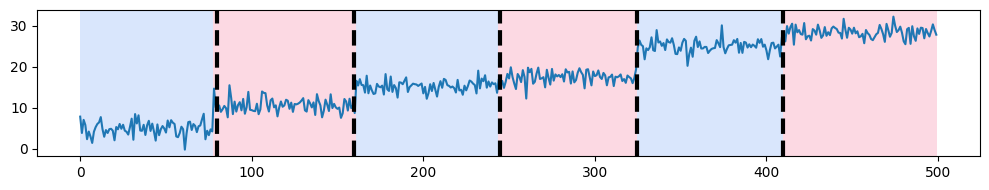

CPs predicted by KernelCPD: [78, 161, 249, 325, 409, 500]


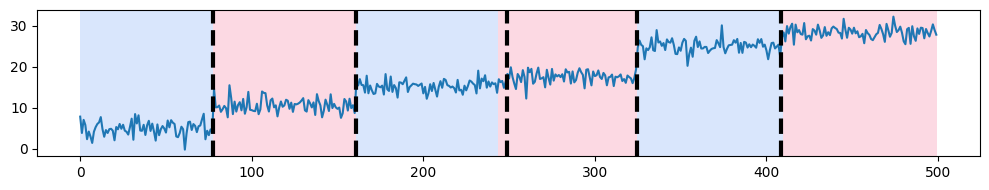

In [4]:
results_dict = dict()

algo = rpt.Binseg(model="l2").fit(signal)
result_binseg = algo.predict(n_bkps=n_cps)
results_dict["binseg"] = result_binseg 

print("CPs predicted by Binseg:", result_binseg)

rpt.display(signal, cps, result_binseg)
plt.show()
# -----------------------------------------------#

algo = rpt.Dynp(model="l2").fit(signal)
result_dynp = algo.predict(n_bkps=n_cps)
results_dict["dynp"] = result_dynp 

print("CPs predicted by Dynp:", result_dynp)

rpt.display(signal, cps, result_dynp)
plt.show()
# -----------------------------------------------#

algo = rpt.Pelt(model="l2").fit(signal)
result_pelt = algo.predict(pen=50)
results_dict["pelt"] = result_pelt 

print("CPs predicted by PELT:", result_pelt)

rpt.display(signal, cps, result_pelt)
plt.show()
# -----------------------------------------------#

algo = rpt.KernelCPD(kernel="rbf").fit(signal)
result_kernel = algo.predict(n_bkps=n_cps)
results_dict["kernel"] = result_kernel 

print("CPs predicted by KernelCPD:", result_kernel)

rpt.display(signal, cps, result_kernel)
plt.show()

### Evaluation metrics

1. Classification-based metrics (e.g. precision, recall, F1) with specific interpretation
    - Option 1:
    - Option 2:

2. Segmentation-based metrics (e.g. Hausdorff metric, Rand index, Covering score, etc.)
3. Specific CPD metrics (e.g. Detection Delay, Time for False Alarm, Area under the Detection Curve)

In ruptures, there metrics groups 1 and 2. We'll have a look at the task-specific metrics later.

In [5]:
for model, preds in results_dict.items():
    pr, rec = precision_recall(cps, preds, margin=10) # margin = 10 by default
    haus = hausdorff(cps, preds)
    rand = randindex(cps, preds)
    print(f"Model: {model}")
    print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")
    print("-" * 52)

Model: binseg
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: dynp
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: pelt
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: kernel
prec = 1.0, rec = 1.0, hausdorff = 5.0, rand = 0.99
----------------------------------------------------


We see that all the models perfectly solve this trivial CPD task. Let's have a look at

## Part 2: real 3D data

'Beedance' records the pixel locations in x and y dimensions and angle differences of bee movements. Ethologists are interested in the three-stages bee waggle dance and aim at identifying the change point from one stage to another, where different stages serve as the communication with other honey bees about the location of pollen and water. See [link](https://sites.cc.gatech.edu/~borg/ijcv_psslds/).

In [10]:
def load_data(data_path, dataset):
    data_raw = sio.loadmat(f"{data_path}/{dataset}.mat")
    
    data = data_raw['Y']                                   
    target = data_raw['L']

    if dataset == "fishkiller":
        subseq_len = 5000
        data, target = data[:subseq_len], target[:subseq_len]
        cps = list(np.where(np.diff(target.flatten()) != 0)[0])
    elif dataset == "beedance":
        cps = list(np.where(target.flatten() != 0)[0])

    cps.append(len(target))
    return data, cps

In [11]:
data, cps = load_data(data_path="data", dataset="beedance")

print("Data shape   :", data.shape)
print("Num of change points:", len(cps))

Data shape   : (1057, 3)
Num of change points: 20


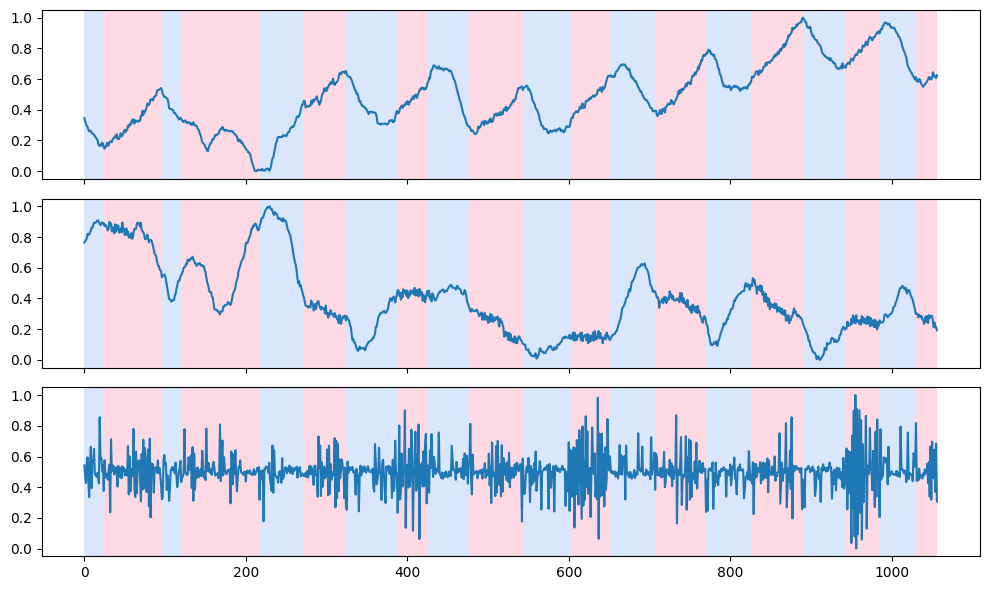

In [12]:
rpt.display(data, cps)
plt.show()

Let's use the same algorithms from ryptures for this time series as well.

CPs predicted by Binseg: [70, 90, 145, 200, 255, 270, 335, 360, 385, 470, 520, 630, 665, 700, 755, 800, 855, 970, 1010, 1025, 1057]


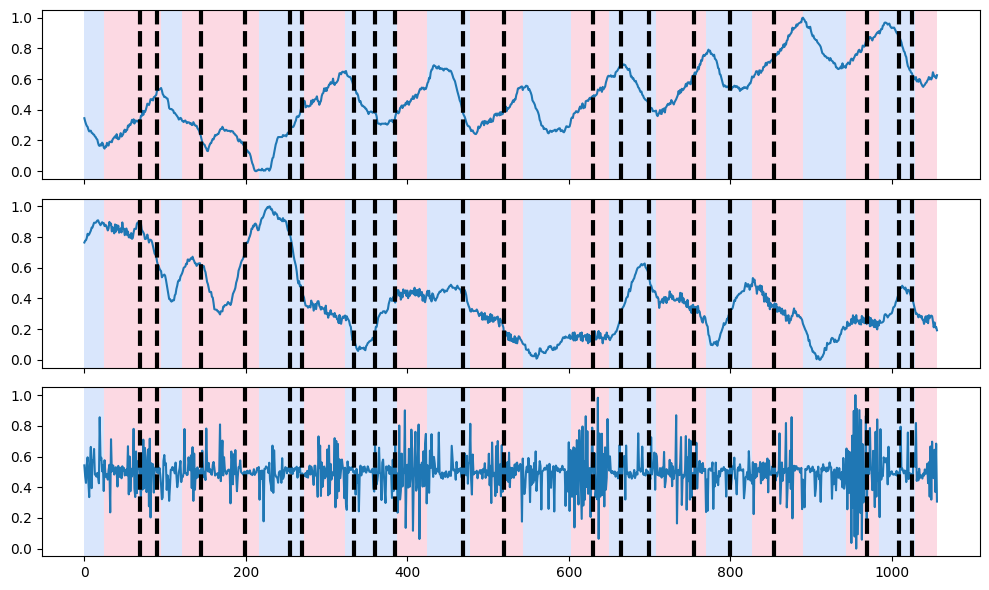

CPs predicted by Dynp: [85, 145, 195, 260, 295, 335, 365, 405, 470, 520, 560, 620, 670, 700, 750, 800, 855, 900, 955, 1020, 1057]


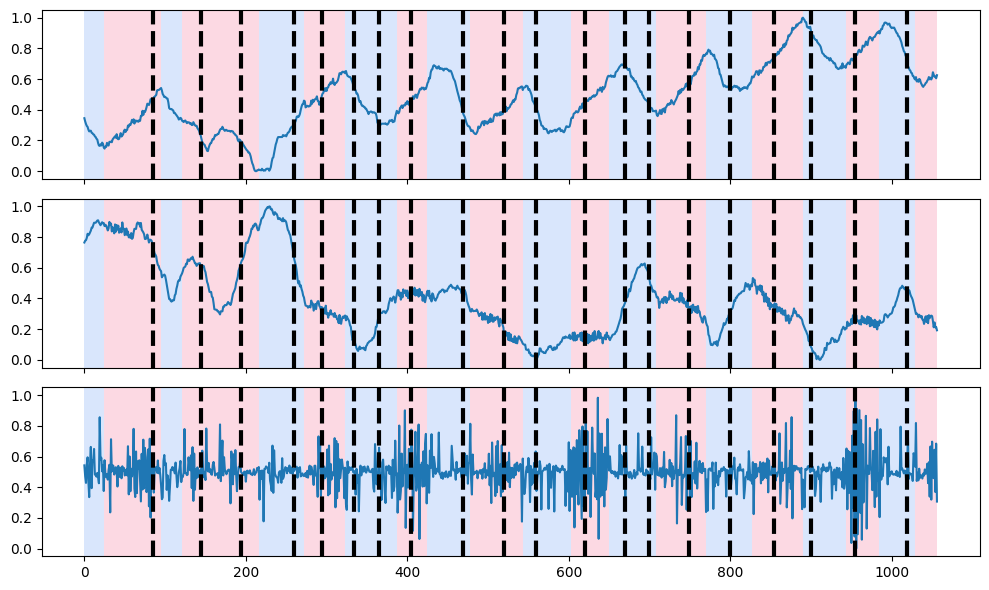

CPs predicted by PELT: [85, 145, 195, 260, 295, 335, 365, 405, 470, 520, 635, 670, 750, 800, 855, 900, 955, 1020, 1057]


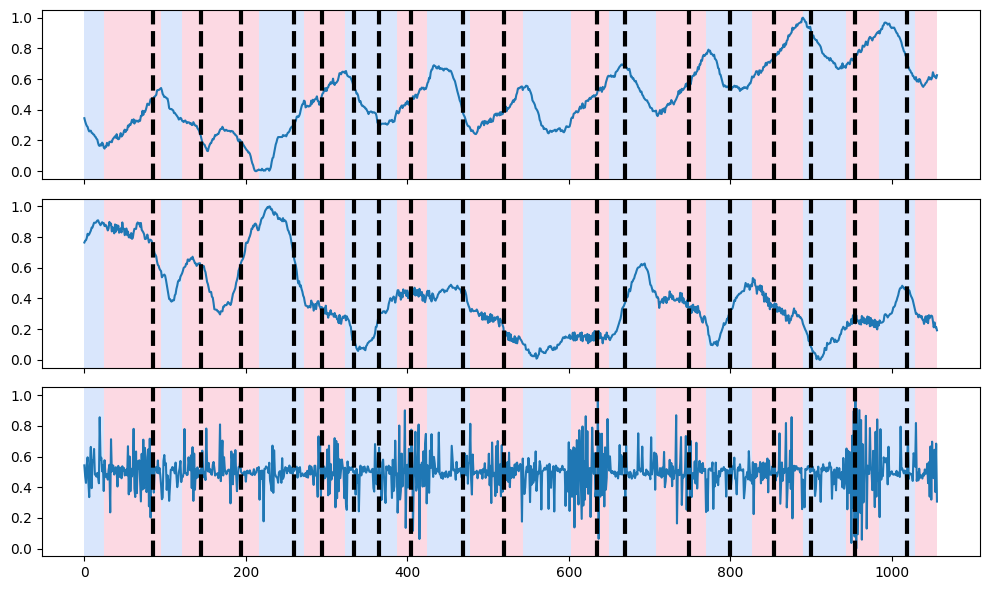

CPs predicted by KernelCPD: [84, 145, 197, 261, 295, 332, 363, 416, 467, 520, 562, 613, 666, 700, 752, 800, 858, 900, 950, 1019, 1057]


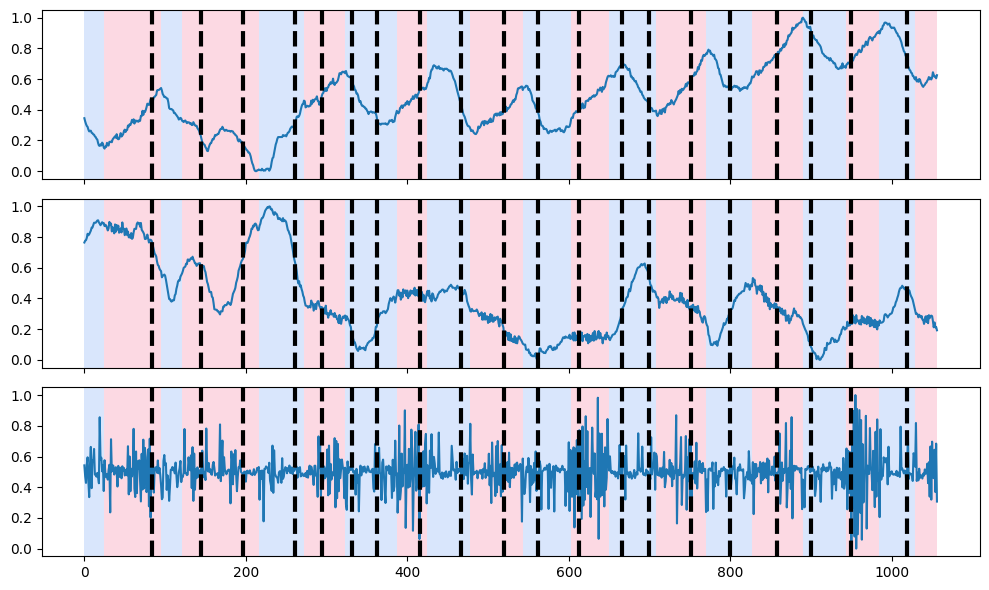

In [13]:
n_cps = len(cps)
results_dict = dict()

algo = rpt.Binseg(model="l2").fit(data)
result_binseg = algo.predict(n_bkps=n_cps)
results_dict["binseg"] = result_binseg

print("CPs predicted by Binseg:", result_binseg)

rpt.display(data, cps, result_binseg)
plt.show()
# -----------------------------------------------#

algo = rpt.Dynp(model="l2").fit(data)
result_dynp = algo.predict(n_bkps=n_cps)
results_dict["dynp"] = result_dynp 

print("CPs predicted by Dynp:", result_dynp)

rpt.display(data, cps, result_dynp)
plt.show()
# -----------------------------------------------#

algo = rpt.Pelt(model="l2").fit(data)
result_pelt = algo.predict(pen=0.7)
results_dict["pelt"] = result_pelt 

print("CPs predicted by PELT:", result_pelt)

rpt.display(data, cps, result_pelt)
plt.show()
# -----------------------------------------------#

algo = rpt.KernelCPD(kernel="rbf").fit(data)
result_kernel = algo.predict(n_bkps=n_cps)
results_dict["kernel"] = result_kernel 

print("CPs predicted by KernelCPD:", result_kernel)

rpt.display(data, cps, result_kernel)
plt.show()

In [14]:
for model, preds in results_dict.items():
    pr, rec = precision_recall(cps, preds, margin=10)
    haus = hausdorff(cps, preds)
    rand = randindex(cps, preds)
    print(f"Model: {model}")
    print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")
    print("-" * 52)

Model: binseg
prec = 0.3, rec = 0.32, hausdorff = 45.0, rand = 0.95
----------------------------------------------------
Model: dynp
prec = 0.2, rec = 0.21, hausdorff = 60.0, rand = 0.96
----------------------------------------------------
Model: pelt
prec = 0.17, rec = 0.16, hausdorff = 60.0, rand = 0.95
----------------------------------------------------
Model: kernel
prec = 0.25, rec = 0.26, hausdorff = 59.0, rand = 0.96
----------------------------------------------------


### Optimal CPD: CUSUM-statistic

Use 1D 'fishkiller' data here.

In [15]:
data, cps = load_data(data_path="data", dataset="fishkiller")

print("Data shape   :", data.shape)
print("Num of change points:", len(cps))

Data shape   : (5000, 1)
Num of change points: 11


In [28]:
def cusum_detector(series, threshold):
    normal_to_change_stat, change_to_normal_stat  = np.zeros(len(series)), np.zeros(len(series))
    normal_to_change_ind, change_to_normal_ind  = [], []
    
    all_change_idxs = []
    for i in range(1, len(series)):
        t = series[i] - series[i - 1]
        normal_to_change_stat[i] = max(0, normal_to_change_stat[i - 1] + t)
        change_to_normal_stat[i] = max(0, change_to_normal_stat[i - 1] - t)
        
        if normal_to_change_stat[i] > threshold:
            normal_to_change_ind.append(i)
            all_change_idxs.append(i)
            normal_to_change_stat[i] = 0
        if change_to_normal_stat[i] > threshold:
            change_to_normal_ind.append(i)
            all_change_idxs.append(i)
            change_to_normal_stat[i] = 0
            
    all_change_idxs.append(len(series))
        
    return all_change_idxs

In [19]:
result_cusum = cusum_detector(data, 0.09)
result_cusum

[956, 2030, 2041, 2124, 2204, 2264, 3346, 4094, 4300, 4374, 4378, 5000]

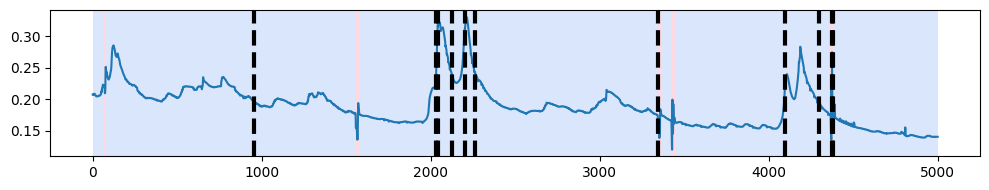

prec = 0.18, rec = 0.2, hausdorff = 888.0, rand = 0.84


In [27]:
rpt.display(data, cps, result_cusum)
plt.show()

pr, rec = precision_recall(cps, result_cusum, margin=100)
haus = hausdorff(cps, result_cusum)
rand = randindex(cps, result_cusum)

print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")

## Part 3: music segmentation with ruptures

## Part 4: Neural CPD

In [ ]:
# !pip install comet-ml

In [2]:
import yaml

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from utils import datasets, metrics, core_models, cpd_models, tscp
from utils.visualize import visualize_predictions

In [3]:
SEED = 42
seed_everything(42)

Global seed set to 42


42

### Human Activity Recognition dataset

In [4]:
experiments_name = "human_activity"
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

len(train_dataset), len(test_dataset)

(3580, 1337)

### Non-trainable baselines

In [5]:
# best model for HAR is KernelCPD with 'rbf' kernel and pen=0.3

baseline_model = cpd_models.ClassicBaseline(rpt.KernelCPD(kernel="rbf"), pen=0.3)
_ = metrics.calculate_baseline_metrics(baseline_model, test_dataloader, verbose=True, margin_list=[1, 2, 4, 6])

TN: 4, FP: 635, FN: 0, TP: 698
DELAY: 0.07, FP_DELAY:6.14
F1:0.6873
COVER: 0.8638
Max F1 with margin 1: 0.7287
Max F1 with margin 2: 0.7731
Max F1 with margin 4: 0.786
Max F1 with margin 6: 0.8039


### BCE model

In [8]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config,'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

In [11]:
core_model_bce = core_models.BaseRnn(**args_config["model"])
core_model_bce

BaseRnn(
  (lstm): LSTM(28, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [12]:
# define CPDModel with BCE loss
bce_model = cpd_models.CPDModel(
    loss_type="bce",
    args=args_config,
    model=core_model_bce,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)
bce_model

CPDModel(
  (model): BaseRnn(
    (lstm): LSTM(28, 8, num_layers=2, batch_first=True, dropout=0.5)
    (linear): Linear(in_features=8, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (loss): BCELoss()
)

In [13]:
# use logger
logger = CometLogger(
    api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
    project_name="cpd-seminar",
    workspace="stalex2902",
    save_dir="logs/",
    experiment_name="BCE_HAR_default"
)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    callbacks=EarlyStopping(**args_config["early_stopping"]) # use early stopping
)
trainer.fit(bce_model)

torch.save(bce_model.state_dict(), "saved_models/bce_har_default.pth")

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.8 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


/home/as_cpd/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/as_cpd/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-seminar/0c0c0c20273941e7b8640d3b08276379



COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/stalex2902/cpd-seminar/0c0c0c20273941e7b8640d3b08276379
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_acc [97]  : (0.6328125, 0.9984375238418579)
COMET INFO:     train_loss [97] : (0.012895300053060055, 0.6719939708709717)
COMET INFO:     val_acc [87]    : (0.6367613673210144, 0.9893417954444885)
COMET INFO:     val_loss [87]   : (0.030869152396917343, 0.6680164337158203)
COMET INFO:   Others:
COMET INFO:     Name : BCE_HAR_default
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO: 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, torch.


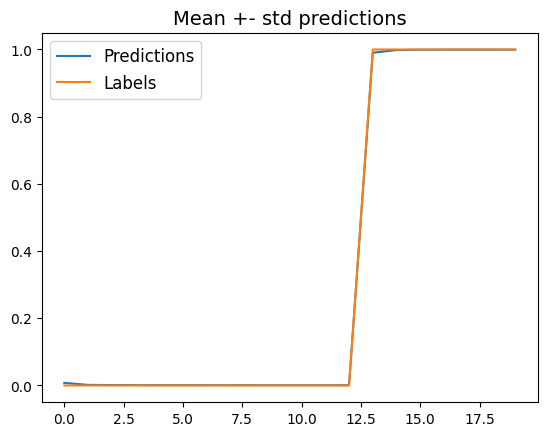

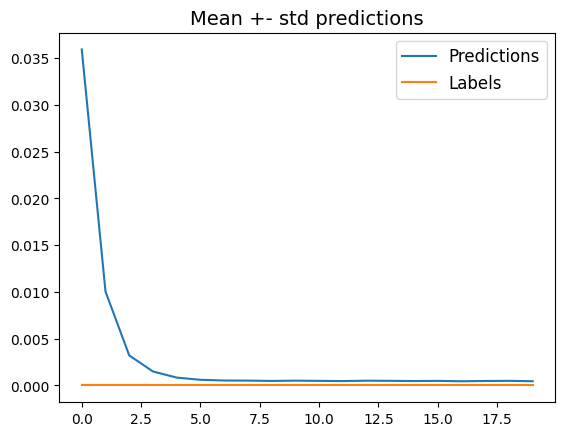

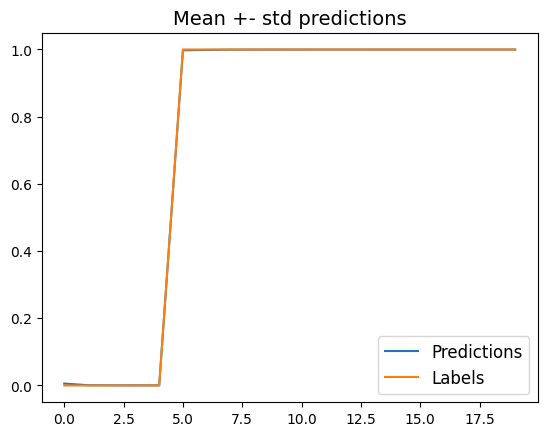

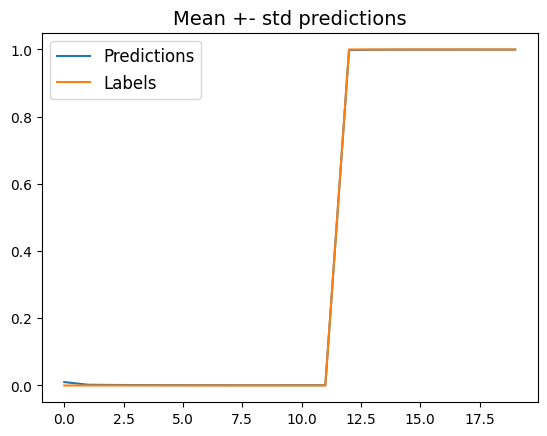

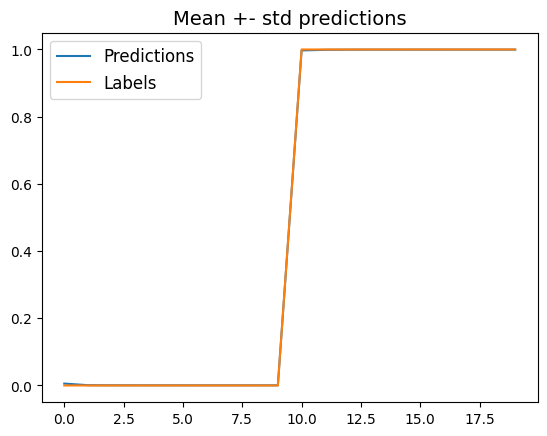

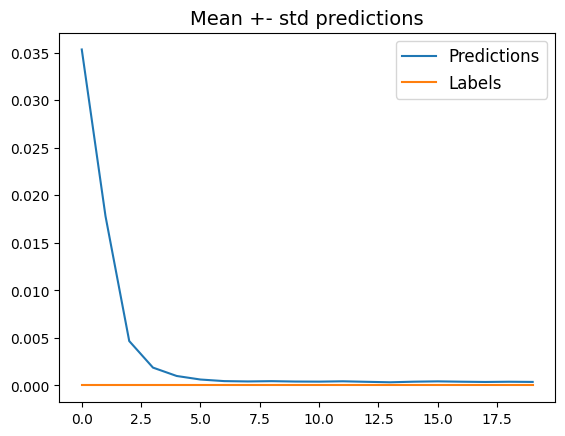

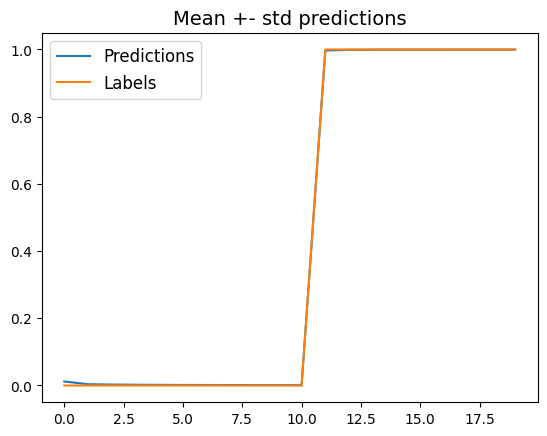

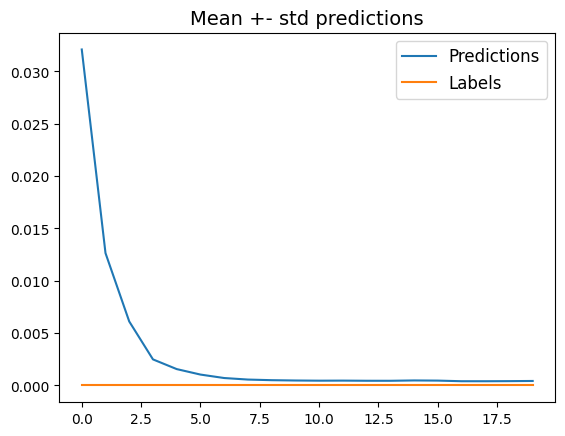

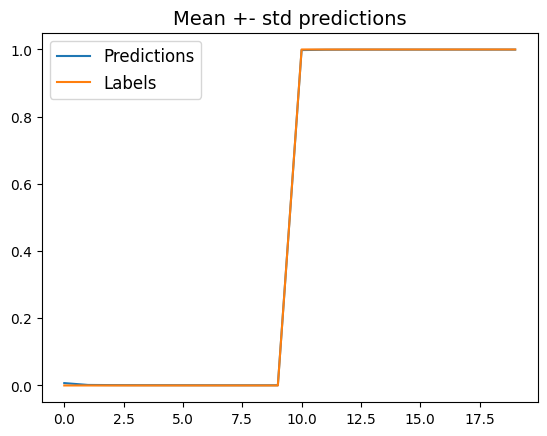

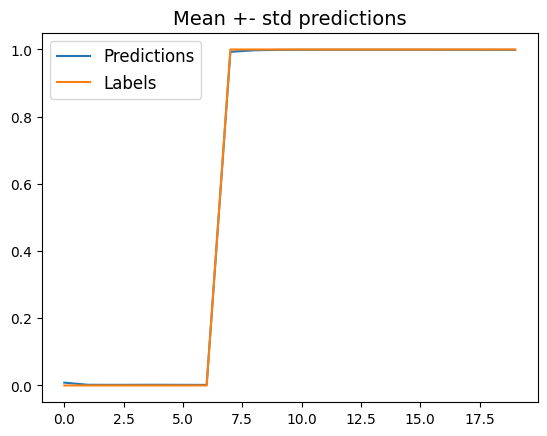

In [25]:
vis_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_batch, test_labels = next(iter(vis_dataloader))

visualize_predictions(
    bce_model,
    model_type="seq2seq",
    sequences_batch=test_batch,
    labels_batch=test_labels,
    n_pics=10
)

In [18]:
# create list of thresholds from [0, 1]
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

_, _, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(bce_model,
                                bce_model.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="seq2seq",
                                margin_list=[1, 2, 4],
                               )

100%|██████████| 84/84 [00:01<00:00, 60.15it/s]


AUC: 39.8317
Time to FA 10.7644, delay detection 0.2087 for best-F1 threshold: 0.7903
TN 170, FP 3, FN 12, TP 1152 for best-F1 threshold: 0.7903
Max F1 0.9935: for best-F1 threshold 0.7903
COVER 0.9934: for best-F1 threshold 0.7903
Max COVER 0.9938: for threshold 0.6249
Max F1 with margin 1: 0.9905 for best threshold 0.6249
Max F1 with margin 2: 0.9909 for best threshold 0.6249
Max F1 with margin 4: 0.9914 for best threshold 0.7903


## TS-CP model

In [10]:
model_type = "tscp"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config,'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

In [11]:
core_model_tscp = tscp.BaseTSCPEncoder(args_config)
core_model_tscp

BaseTSCPEncoder(
  (tcn_layer): TCN(
    (residual_blocks): ModuleList(
      (0): ResidualBlock(
        (conv_1): Conv1d(28, 64, kernel_size=(5,), stride=(1,))
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (relu_1): ReLU()
        (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (relu_2): ReLU()
        (conv_block): Sequential()
        (downsample): Conv1d(28, 64, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): ResidualBlock(
        (conv_1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), dilation=(2,))
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_aff

In [12]:
tscp_model = tscp.TSCP_model(
    args_config,
    core_model_tscp,
    train_dataset,
    test_dataset
)

In [14]:
# use logger
model_name = f'tscp_har_seed_{SEED}'
logger = CometLogger(
    api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
    project_name="cpd-seminar",
    workspace="stalex2902",
    save_dir="logs/",
    experiment_name="TSCP_HAR_default"
)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    # use early stopping
    callbacks=EarlyStopping(**args_config["early_stopping"])
)

trainer.fit(tscp_model)

torch.save(tscp_model.state_dict(), "saved_models/tscp_har_default.pth")

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | BaseTSCPEncoder | 327 K 
------------------------------------------
327 K     Trainable params
0         Non-trainable params
327 K     Total params
1.310     Total estimated model params size (MB)


/home/as_cpd/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/as_cpd/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/stalex2902/cpd-seminar/02a619fa30b2407d964c5d4fbfe66e8a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     neg_sim_step [8]    : (-0.041587382555007935, 0.3677808940410614)
COMET INFO:     pos_sim_step [8]    : (0.7171378135681152, 0.9978624582290649)
COMET INFO:     train_loss_step [8] : (0.00582444341853261, 0.08427916467189789)
COMET INFO:     val_loss            : 0.2590581774711609
COMET INFO:   Others:
COMET INFO:     Name : TSCP_HAR_default
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/stalex2902/cpd-seminar/ea6aa76fcccd4ff2bd8dd14bb8f5f866
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     neg_sim_epoch [33]    : (0.011303525418043137, 0.08509819209575653)
COMET INFO:     neg_sim_step [295]    : (-0.12869831919670105, 0.5601921081542969)
COMET INFO:     pos_sim_epoch [33]    : (0.7999874949455261, 0.8157442212104797)
COMET INFO:     pos_sim_step [295]    : (0.12264189124107361, 0.9996228218078613)
COMET INFO:     train_loss_epoch [33] : (0.008602810092270374, 0.026374023407697678)
COMET INFO:     train_loss_step [295] : (0.0003791621420532465, 0.07790344953536987)
COMET INFO:     val_loss [33]         

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


In [29]:
# create list of thresholds from [0, 1]
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

_, _, delay_list_tscp, fp_delay_list_tscp = \
    metrics.evaluation_pipeline(tscp_model,
                                tscp_model.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="tscp",
                                margin_list=[1, 2, 4, 6],
                                scale=args_config["predictions"]["scale"]
                               )

  0%|          | 0/168 [00:00<?, ?it/s]

100%|██████████| 168/168 [00:08<00:00, 20.50it/s]


AUC: 68.1019
Time to FA 10.4338, delay detection 2.635 for best-F1 threshold: 0.3287
TN 155, FP 71, FN 79, TP 1032 for best-F1 threshold: 0.3287
Max F1 0.9322: for best-F1 threshold 0.3287
COVER 0.7675: for best-F1 threshold 0.3287
Max COVER 0.7831: for threshold 0.2853
Max F1 with margin 1: 0.1038 for best threshold 0.2853
Max F1 with margin 2: 0.5251 for best threshold 0.2853
Max F1 with margin 4: 0.8908 for best threshold 0.2853
Max F1 with margin 6: 0.9312 for best threshold 0.2853


#### Detection Curves

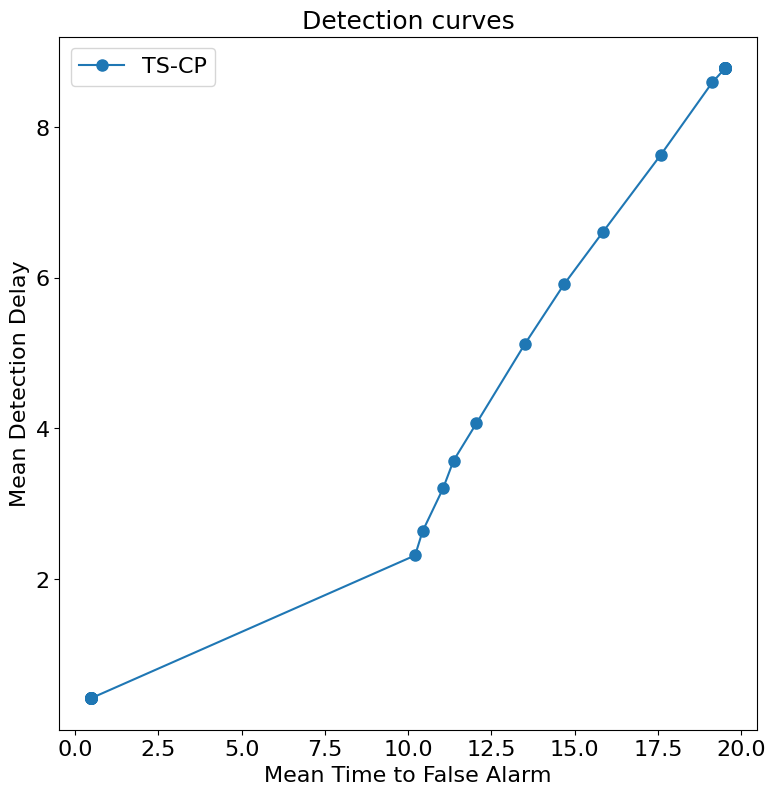

In [31]:
plt.figure(figsize=(9, 9))
plt.plot(fp_delay_list_bce.values(), delay_list_bce.values(), '-o', markersize=8, label="BCE seq2seq model")
plt.plot(fp_delay_list_tscp.values(), delay_list_tscp.values(), '-o', markersize=8, label="TS-CP model")
plt.title("Detection curves", fontsize=18)
plt.xlabel('Mean Time to False Alarm', fontsize=16)
plt.ylabel('Mean Detection Delay', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.show()